# LSLGA/DR9-SV QA

In [1]:
import os, glob
import fitsio
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import vstack, Table, hstack

In [2]:
import seaborn as sns
sns.set(context='talk', style='ticks', font_scale=1.2)
%matplotlib inline

In [3]:
outdir = '/global/project/projectdirs/desi/users/ioannis/dr9sv-lslga'
if not os.path.isdir(outdir):
    os.makedirs(outdir, exist_ok=True)

In [4]:
drdir = '/global/cfs/cdirs/cosmo/work/legacysurvey/dr9sv'
sweepdir = drdir

#### Read the reference LSLGA.

In [17]:
lslgaver = b'L5'
lslgafile = '/global/project/projectdirs/cosmo/staging/largegalaxies/v5.0/LSLGA-v5.0.kd.fits'
#lslgafile = os.getenv('LARGEGALAXIES_CAT')
lslga = Table(fitsio.read(lslgafile))
print('Read {} galaxies from {}'.format(len(lslga), lslgafile))
#lslga

Read 479481 galaxies from /global/project/projectdirs/cosmo/staging/largegalaxies/v5.0/LSLGA-v5.0.kd.fits


#### Get the set of completed bricks.

In [18]:
#bricks = glob.glob(os.path.join(drdir, 'tractor', '???', '*.fits'))
#tractor = vstack([Table(fitsio.read(catfile)) for catfile in bricks])
#bricks

In [19]:
def match_tractor_lslga(northsouth='south', overwrite=False):
    """Match to all the LSLGA galaxies and also gather 
    all the Sersic galaxies.
    
    """
    cols = ['RA', 'DEC', 'TYPE', 'BRICKNAME', 'REF_CAT', 
            'SERSIC', 'SHAPE_R', 'SHAPE_E1', 'SHAPE_E2', 
            'FLUX_R', 'REF_ID']

    outfile = os.path.join(outdir, 'dr9d-lslga-{}.fits'.format(northsouth))
    outfile_sersic = os.path.join(outdir, 'dr9d-sersic-{}.fits'.format(northsouth))
    if not os.path.isfile(outfile) or not os.path.isfile(outfile_sersic) or overwrite:
        out, outsersic = [], []
        catfile = glob.glob(os.path.join(sweepdir, northsouth, 'sweep', 'sweep-*.fits'))
        #catfile = glob.glob(os.path.join(drdir, 'dr9d-{}'.format(northsouth), 'tractor', '???', 'tractor*.fits'))
        if len(catfile) == 0:
            print('No catalogs found!')
            return
        #for ii, ff in enumerate(catfile[:2]):
        for ii, ff in enumerate(catfile):
            if ii % 5 == 0:
                print('{} / {}'.format(ii, len(catfile)))
            #import pdb ; pdb.set_trace()
            cc = fitsio.read(ff, columns=cols, upper=True)
            #print(cc['REF_CAT'])
            ckeep = np.where(cc['REF_CAT'] == lslgaver)[0]
            if len(ckeep) > 0:
                out.append(Table(cc[ckeep]))
            skeep = np.where(cc['TYPE'] == b'SER')[0]
            if len(skeep) > 0:
                outsersic.append(Table(cc[skeep]))
        if len(out) == 0:
            print('No large galaxies!')
            return
        if len(outsersic) == 0:
            print('No Sersic galaxies!')
        else:
            outsersic = vstack(outsersic)
            print('Writing {} galaxies to {}'.format(len(outsersic), outfile_sersic))
            outsersic.write(outfile_sersic, overwrite=True)
            
        out = vstack(out)
        
        # find and remove duplicates
        #uval, cnt = np.unique(out['REF_ID'], return_counts=True)
        #dup_refid = uval[cnt > 1]

        # now match against the LSLGA
        #import pdb ; pdb.set_trace()
        match = [np.where(refid == lslga['LSLGA_ID'])[0] for refid in out['REF_ID']]
        if len(match) == 0:
            print('No matching large galaxies!')
            return
        match = np.hstack(match)
        
        lss = lslga[match]
        lss.rename_column('RA', 'RA_LSLGA')
        lss.rename_column('DEC', 'DEC_LSLGA')
        lss.rename_column('TYPE', 'MORPHTYPE')

        out = hstack((lss, out))
        
        print('Writing {} galaxies to {}'.format(len(out), outfile))
        out.write(outfile, overwrite=True)
    else:
        out = Table(fitsio.read(outfile))
        print('Read {} galaxies from {}'.format(len(out), outfile))

        outsersic = Table(fitsio.read(outfile_sersic))
        print('Read {} galaxies from {}'.format(len(outsersic), outfile_sersic))
    return out, outsersic

In [20]:
%time south, sersouth = match_tractor_lslga(northsouth='south', overwrite=False)

0 / 50
[b'G2' b'  ' b'G2' ... b'  ' b'G2' b'G2']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'G2']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'G2' b'G2' ... b'  ' b'  ' b'  ']
5 / 50
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'G2']
[b'G2' b'  ' b'G2' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
10 / 50
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'G2' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'G2']
[b'G2' b'G2' b'G2' ... b'  ' b'G2' b'G2']
15 / 50
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'G2']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'G2' b'G2' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'G2']
20 / 50
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'G2' b'  ' ... b'  ' b'  ' b'G2']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b' 

In [21]:
%time north, sernorth = match_tractor_lslga(northsouth='north', overwrite=False)

0 / 43
[b'  ' b'  ' b'G2' ... b'  ' b'G2' b'G2']
[b'  ' b'  ' b'G2' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
5 / 43
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'G2']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
10 / 43
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'G2' b'G2' ... b'  ' b'  ' b'G2']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'G2' b'  ' b'  ' ... b'  ' b'  ' b'  ']
15 / 43
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' ... b'  ' b'  ' b'  ']
[b'  ' b'  ' b'  ' b'G2' b'  ' b'  ' b'  ' b'  ' b'  ' b'  ' b'G2' b'  '
 b'  ' b'  ' b'  ' b'  ' b'  ' b'  ' b'  ' b'  ' b'  ' b'  ' b'  ' b'  '
 b'  ' b'  ' b'  ' b'  ' b

### Make some plots!

In [22]:
def qa_sersic(allcat, label):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for cat, lab, thisax in zip(allcat, label, ax.flat):
        ww = cat['FLUX_R'] > 0
        r50 = cat['SHAPE_R'][ww]
        sersicn = cat['SERSIC'][ww]
        rmag = 22.5-2.5*np.log10(cat['FLUX_R'][ww])
        thisax.scatter(rmag, sersicn, s=1, alpha=0.7)
        thisax.set_xlim(15, 23)
        thisax.set_xlabel(r'$r$ (AB mag)')
        thisax.set_title(lab)
    ax[0].set_ylabel('Sersic $n$')
    plt.subplots_adjust(wspace=0.1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for cat, lab, thisax in zip(allcat, label, ax.flat):
        ww = cat['FLUX_R'] > 0
        r50 = cat['SHAPE_R'][ww]
        sersicn = cat['SERSIC'][ww]
        rmag = 22.5-2.5*np.log10(cat['FLUX_R'][ww])
        thisax.scatter(np.log10(r50), sersicn, s=1, alpha=0.7)
        thisax.set_xlim(-1, 2)
        thisax.set_xlabel(r'$\log_{10}\ r_{50}$ (arcsec)')
        thisax.set_title(lab)
    ax[0].set_ylabel('Sersic $n$')
    plt.subplots_adjust(wspace=0.1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for cat, lab, thisax in zip(allcat, label, ax.flat):
        ww = cat['FLUX_R'] > 0
        r50 = cat['SHAPE_R'][ww]
        sersicn = cat['SERSIC'][ww]
        rmag = 22.5-2.5*np.log10(cat['FLUX_R'][ww])
        _ = thisax.hist(sersicn[sersicn > 1], bins=50)#, range=(1, 4))    
        thisax.set_yscale('log')
        thisax.set_xlabel('Sersic $n$')
        thisax.set_title(lab)
    ax[0].set_ylabel('Number of Galaxies')
    plt.subplots_adjust(wspace=0.1)

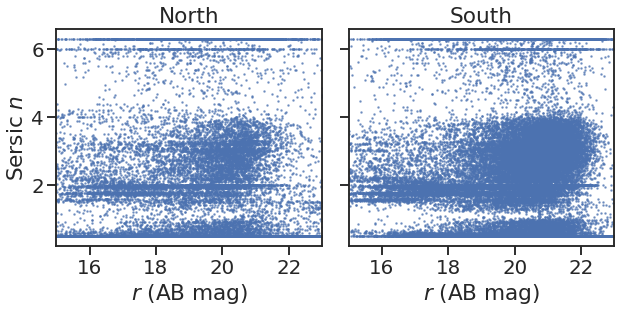

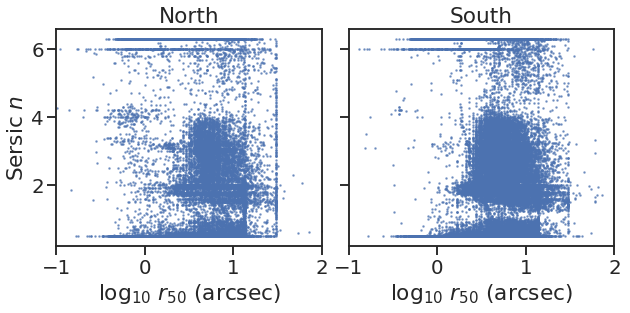

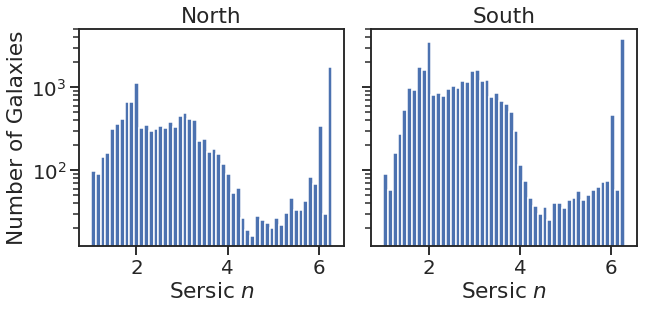

In [23]:
qa_sersic((sernorth, sersouth), ('North', 'South'))